# マリオAIチャレンジ 1-1

AIを使ってマリオを全ステージクリアするチャレンジ「Mario Ai Challenge」のステージ1-1のノートブックです。

プロジェクトページ（GitHub Pages）は以下となります。

https://karaage0703.github.io/mario-ai-challenge/


以下のIssueで共有されているNotebookをベースにしたものです。

https://github.com/karaage0703/mario-ai-challenge/issues/1

また、本ノートブックはGoogle ColabではなくRTX 3060搭載のWindowsマシンにて実行して作成されました。
そのためGoogle Colabでのみ必要なセルについてはコメントアウトされています。
Google Colabで使用する際は適宜コメントを解除してください。## 最初に
本チャレンジは、PyTorch公式のチュートリアルの[Train a MARIO-Playing RL Agent](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html)及び、その日本語訳の[PyTorchチュートリアル（日本語翻訳版）](https://yutaroogawa.github.io/pytorch_tutorials_jp/)の「強化学習を用いたマリオの訓練」、その他多くのWeb上の知見を参考に作成しました。

本ノートブックのライセンスは、上記のチュートリアルのライセンスに準じたものになります（詳細は、それぞれのリンク先で確認ください）。参考にしたサイトなどは、本記事の最後にまとめて掲載いたします。貴重な知見の公開に感謝いたします。

また、本ノートブックはGoogle ColabではなくRTX 3060搭載のWindowsマシン/RTX 2070 SUPER搭載のUbuntuマシンにて実行して作成されました。  
そのためGoogle Colabでのみ必要なセルについてはコメントアウトされています。
Google Colabで使用する際は適宜コメントを解除してください。

## ハイパーパラメータの設定
主要なハイパーパラメータを最初に設定します。

In [1]:
# Env Param
STAGE_NAME = 'SuperMarioBros-1-1-v0'
SKIP_NUMB = 2
# STACK_FRAME_NUMB = 4
# RESIZE_SIZE = 84
DOWN_SAMPLE_RATE = 3

# Model Param
CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 500000
LEARNING_RATE = 0.00005
# GAE = 1.0
# ENT_COEF = 0.01
N_STEPS = 512
GAMMA = 0.9
BATCH_SIZE = 64
N_EPOCHS = 10

# Test Param
EPISODE_NUMBERS = 20
# MAX_TIMESTEP_TEST = 1000

## Google Driveとの連携

Google Driveに学習したモデルを保存するために実施します。

モデルのGoogle Driveへの保存が不要ならここは飛ばしてもOKです。

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Google Driveにログ用のディレクトリを作成

In [2]:
import os
# LOG_DIR = '/content/drive/MyDrive/gym_mario/'
LOG_DIR = './logs/'
if os.path.exists(LOG_DIR):
    print('log dir exist.')
else:
    print('log dir not exist.')
    os.makedirs(LOG_DIR)

log dir exist.


## 必要なライブラリのインストールとインポート
AIマリオに必要なライブラリのインストールとインポートを行います。

[OpenAI Gymのマリオ用パッケージ](https://github.com/Kautenja/gym-super-mario-bros)をインストールします。強化学習の環境として使用します。詳細の仕様は[GitHub](https://github.com/Kautenja/gym-super-mario-bros)参照ください。


In [ ]:
#!pip install -qq gym-super-mario-bros==7.3.0

その他、必要なライブラリをインストールします。

In [ ]:
#!apt -qq update
#!apt install -y -qq xvfb
#!pip install -qq pyvirtualdisplay

必要なライブラリをインポートします。

In [3]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

強化学習に使われる`stable-baselines3`というライブラリをインストールします。ドキュメントは以下参照ください。

https://stable-baselines3.readthedocs.io/en/master/index.html

In [ ]:
## Install stable baselines for RL stuff
#!pip -qq install stable-baselines3[extra]==1.3.0

`stable-baselines3`と、そのバックエンドに使われている`PyTorch`のバージョンを確認しておきます。

In [4]:
!pip show stable-baselines3

Name: stable-baselines3
Version: 1.3.0
Summary: Pytorch version of Stable Baselines, implementations of reinforcement learning algorithms.
Home-page: https://github.com/DLR-RM/stable-baselines3
Author: Antonin Raffin
Author-email: antonin.raffin@dlr.de
License: MIT
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy, matplotlib, pandas, torch, gym, cloudpickle
Required-by: 


In [5]:
!pip show torch

Name: torch
Version: 1.10.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/conda/lib/python3.7/site-packages
Requires: typing_extensions
Required-by: torchvision, torchtext, torchelastic, stable-baselines3


## AIマリオ環境の構築

AIマリオの環境構築を行います。

### AIマリオ環境初期化

In [6]:
# マリオの環境を初期化します。
env = gym_super_mario_bros.make(STAGE_NAME)

# マリオの行動空間を設定
env = JoypadSpace(env, SIMPLE_MOVEMENT)

PyTorchチュートリアルでは、以下のように2パターンに単純化した行動をするマリオに制限されていますが、今回は、もう少し自由度を増やした`SIMPLE_MOVEMENT`を採用します。右に進むほど報酬が得られるので、1-1では、そこまで大きな違いは感じられませんでした。

```
# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
env = JoypadSpace(env, [["right"], ["right", "A"]])
```

環境をリセットして、環境を確認します。

`env.step(action=0)`と、エージェント（マリオ）がアクションすると、環境から状態(`state`)と報酬(`reward`)、終了したかのフラグ(`done`)、情報(`info`)が返ってきます。

In [7]:
env.reset()
state, reward, done, info = env.step(action=0)
print(f"{state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


行動`action`の範囲や状態`state`の範囲を確認しておきます。

In [8]:
from gym.spaces import Box, Discrete
def print_spaces(space):
    print(space)

    if isinstance(space, Box):
        print('min:', space.low)
        print('max:', space.high)
    if isinstance(space, Discrete):
        print('min:', 0)
        print('max:', space.n-1)

In [ ]:
print_spaces(env.action_space)

In [ ]:
print_spaces(env.observation_space)

最後に`state`を画像として可視化してみます。

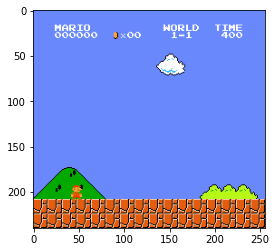

In [9]:
plt.imshow(state)

まさにマリオのプレイ画面ですね。

### AIマリオ環境の前処理
環境に対して、前処理をしていきます。

具体的には、画像のリサイズやグレイスケール化、報酬設計の調整等です。

深層強化学習に限らず、機械学習ではこの前処理が非常に重要となります。

AIマリオ環境のフレームワークとして用いられているOpenAI Gymではカスタムラッパーを使って、環境に前処理を行っていくのがお作法となります。

以下ラッパーの説明をしていきます。

- `SkipFrame`: `gym.Wrapper`を継承し`step()`関数を実装したカスタムのラッパーです。何フレームか同じ行動をとるようにすることで、行動を簡易化しています。
- `GrayScaleObservation`: 画像をグレースケールに変換します。マリオに関しては色はそれほど重要でないと考えられるのでグレースケールを使います。色が重要なゲームでは使えない手法です。
- `Downsample`: 画像を小さくします。[baselinesのretro_wrappers.py](https://github.com/openai/baselines/blob/master/baselines/common/retro_wrappers.py)を参考にしました。
- `VecFrameStack`: 連続したフレームを1つにまとめるラッパーです。これで、マリオの行動をジャンプや走るといった動きとして認識できるようになります。
- `DummyVecEnv`: 学習のために必要なデータ変換となります。詳細は以下などを参照ください。これを実施すると、`env.step(1)`から`env.step([1])`といった形で、アクションの指定の形式が変わります。[こちら](https://note.com/npaka/n/n5d7d235ad8bc)や[こちら](https://kiyosucyberclub.web.fc2.com/OpenAI_Gym/Gym02-01.html)を参照ください。
- `CustomRewardAndDoneEnv`: 報酬や終了条件をカスタムするラッパーです。[こちら](https://qiita.com/hrs1985/items/871ca5d037d73558bfca)のサイトを参考に、マリオが一機死んだら終了するように変更しています。報酬の調整も可能です（今回はしませんでした）。


ラッパーのインポートや定義を行います。

In [10]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [11]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """スキップした後のフレームのみを返す"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """行動を繰り返し、報酬を合計する"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # 報酬を蓄積し、同じ行動を繰り返す
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

In [12]:
# Reference:
# https://github.com/openai/baselines/blob/master/baselines/common/retro_wrappers.py
class StochasticFrameSkip(gym.Wrapper):
    def __init__(self, env, n, stickprob):
        gym.Wrapper.__init__(self, env)
        self.n = n
        self.stickprob = stickprob
        self.curac = None
        self.rng = np.random.RandomState()
        self.supports_want_render = hasattr(env, "supports_want_render")

    def reset(self, **kwargs):
        self.curac = None
        return self.env.reset(**kwargs)

    def step(self, ac):
        done = False
        totrew = 0
        for i in range(self.n):
            # First step after reset, use action
            if self.curac is None:
                self.curac = ac
            # First substep, delay with probability=stickprob
            elif i==0:
                if self.rng.rand() > self.stickprob:
                    self.curac = ac
            # Second substep, new action definitely kicks in
            elif i==1:
                self.curac = ac
            if self.supports_want_render and i<self.n-1:
                ob, rew, done, info = self.env.step(self.curac, want_render=False)
            else:
                ob, rew, done, info = self.env.step(self.curac)
            totrew += rew
            if done: break
        return ob, totrew, done, info

    def seed(self, s):
        self.rng.seed(s)

In [13]:
import cv2

# Reference:
# https://github.com/openai/baselines/blob/master/baselines/common/retro_wrappers.py
class Downsample(gym.ObservationWrapper):
    def __init__(self, env, ratio):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (oldh//ratio, oldw//ratio, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

In [14]:
class CustomRewardAndDoneEnv(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardAndDoneEnv, self).__init__(env)

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        # reward = reward / 10

        # ゴール判定
        if info["flag_get"]:
            reward += 500
            done = True
            print("GOAL")

        # 死亡判定
        if info["life"] < 2:
            reward -= 500
            done = True

        return state, reward, done, info

環境を再度作成して、Wrapperを適用し、前処理を行います。

In [15]:
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = CustomRewardAndDoneEnv(env)
env = SkipFrame(env, skip=SKIP_NUMB)
env = GrayScaleObservation(env, keep_dim=True)
env = Downsample(env, DOWN_SAMPLE_RATE)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

上記のラッパーを環境に適用すると、最終的な状態（ラップされた結果の状態）は、下図の左側の画像のように4つの連続したグレースケールのフレームを重ね合わせたものになります。

マリオが行動を取るたびに、環境はこのような構造を持つ状態を返します。

この構造は、サイズ`[1, 80, 85, 4]`のテンソルで表されます。

最初の1は（多分）`Dummy Vector`の分で`80,85`がダウンサンプリングした画像のサイズ。最後の4連続のフレームになります。

実際の中身を見てみましょう

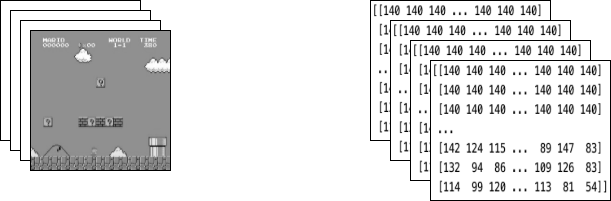

In [16]:
env.reset()
state, reward, done, info = env.step([0])

In [17]:
print(f"{state.shape},\n {reward},\n {done},\n {info}")

(1, 80, 85, 4),
 [0.],
 [False],
 [{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}]


4フレーム分表示します。

In [18]:
def display_all_frame():
    plt.figure(figsize=(20,16))
    for idx in range(state.shape[3]):
        plt.subplot(1,4,idx+1)
        plt.imshow(state[0][:,:,idx])
    plt.show()

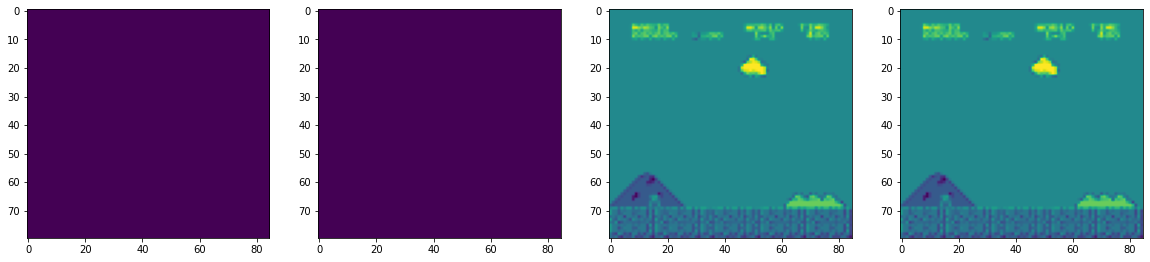

In [19]:
display_all_frame()

右ジャンプの操作をして表示してみます。

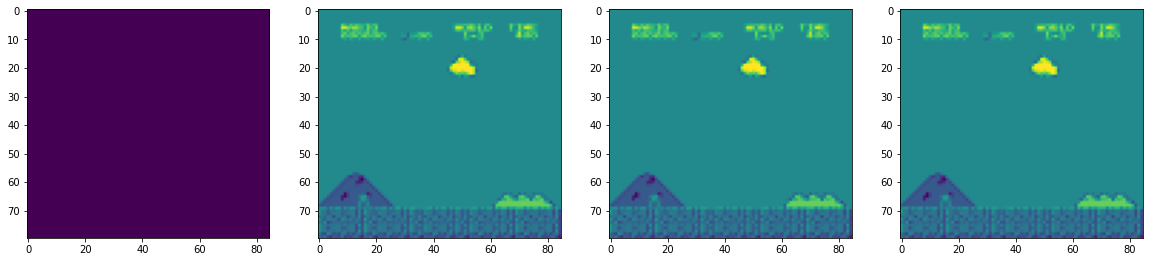

In [20]:
state, reward, done, info = env.step([2])
display_all_frame()

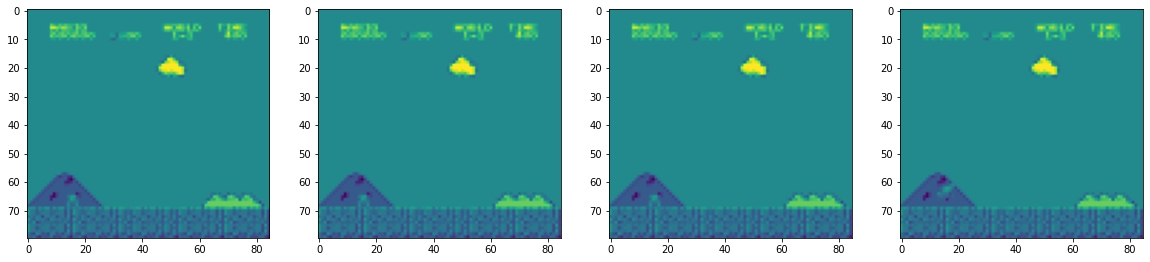

In [21]:
state, reward, done, info = env.step([2])
display_all_frame()

1フレーム目の生値を確認します。この後使用するPPOというモデルは、画素の値がuint8(0-255)前提となります。0-1に正規化したものを使うと以下のエラーがでます。

```
AssertionError: You should use NatureCNN only with images not with Box(0.0, 1.0, (80, 85, 4), float32)
(you are probably using `CnnPolicy` instead of `MlpPolicy` or `MultiInputPolicy`)
If you are using a custom environment,
please check it using our env checker:
https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html
```

In [22]:
state[0][:,:,1]

array([[140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       [140, 140, 140, ..., 140, 140, 140],
       ...,
       [154, 124, 123, ...,  84, 153,  83],
       [123,  93,  80, ..., 112, 124,  83],
       [116, 103, 122, ..., 113,  83,  55]], dtype=uint8)

## AIマリオの学習

AIモデルの学習をします。学習済みのモデルを使う場合は、ここは飛ばして次のAIマリオのテストまで行ってください。

ライブラリをインポートします。

In [23]:
# Import os for file path management
import os
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

ログの設定をします。

In [24]:
# import datetime
# CHECKPOINT_DIR = './train/'
# LOG_DIR = './logs/'
# REWARD_LOG_FILENAME = 'reward_log_{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
# print(REWARD_LOG_FILENAME)
from pathlib import Path
import datetime
from pytz import timezone
save_dir = Path(LOG_DIR) / datetime.datetime.now(timezone('Asia/Tokyo')).strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)
reward_log_path = (save_dir / 'reward_log.csv')
placeholder_path = (save_dir / '{}.txt'.format(STAGE_NAME) )
placeholder_path.touch()
print(reward_log_path)

logs/2022-02-06T13-22-42/reward_log.csv


In [25]:
# with open(REWARD_LOG_FILENAME, 'a') as f:
#     print('timesteps,reward', file=f)
with open(reward_log_path, 'a') as f:
    print('timesteps,reward,best_reward', file=f)

学習のコールバック関数の設定をします。

In [26]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

            total_reward = [0] * EPISODE_NUMBERS
            total_time = [0] * EPISODE_NUMBERS
            best_reward = 0

            for i in range(EPISODE_NUMBERS):
                state = env.reset()  # reset for each new trial
                done = False
                total_reward[i] = 0
                total_time[i] = 0
                while not done and total_time[i] < 10000:
                    action, _ = model.predict(state)
                    state, reward, done, info = env.step(action)
                    total_reward[i] += reward[0]
                    total_time[i] += 1

                if total_reward[i] > best_reward:
                    best_reward = total_reward[i]
                    best_epoch = self.n_calls

                state = env.reset()  # reset for each new trial

            print('time steps:', self.n_calls, '/', TOTAL_TIMESTEP_NUMB)
            print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
                  'average time:', (sum(total_time) / EPISODE_NUMBERS),
                  'best_reward:', best_reward)

            with open(reward_log_path, 'a') as f:
                print(self.n_calls, ',', sum(total_reward) / EPISODE_NUMBERS, ',', best_reward, file=f)

        return True

In [27]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=CHECK_FREQ_NUMB, save_path=save_dir)

AIマリオのモデルを定義します。最初から学習させる場合は以下です。

In [28]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=0, tensorboard_log=save_dir, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
              batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA)

学習済みのモデルを追加学習（ファインチューニング）する場合は、以下コードを参考にモデルを読み込みましょう。

In [ ]:
#import gdown
#gdown.download('https://drive.google.com/uc?id=1Q6loj0KMvJhNXSNqPAetP0DEWItO6Kdm', 'best_model_4230000.zip', quiet=False)
#model_path = 'best_model_4230000'

In [ ]:
# model = PPO.load(model_path, env, verbose=0, tensorboard_log=save_dir, learning_rate=LEARNING_RATE, n_steps=N_STEPS,
#                  batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, gamma=GAMMA, gae_lambda=GAE, ent_coef=ENT_COEF)

AIモデルを学習します。学習済みのモデルを読み込み新たに学習しない場合は飛ばしてください。

この学習は、良いモデルが出来たら途中で止めて次に行ってもOKです。

In [29]:
%%time
model.learn(total_timesteps=TOTAL_TIMESTEP_NUMB, callback=callback)

/opt/conda/lib/python3.7/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


time steps: 10000 / 500000
average reward: 853.4 average time: 982.8 best_reward: 2486.0
time steps: 20000 / 500000
average reward: 682.35 average time: 214.3 best_reward: 2334.0
time steps: 30000 / 500000
average reward: 795.75 average time: 384.3 best_reward: 1865.0
time steps: 40000 / 500000
average reward: 585.5 average time: 205.45 best_reward: 1414.0
time steps: 50000 / 500000
average reward: 712.35 average time: 202.15 best_reward: 1567.0
time steps: 60000 / 500000
average reward: 636.3 average time: 157.95 best_reward: 1346.0
time steps: 70000 / 500000
average reward: 903.4 average time: 265.6 best_reward: 1346.0
time steps: 80000 / 500000
average reward: 776.2 average time: 236.0 best_reward: 1694.0
time steps: 90000 / 500000
average reward: 745.4 average time: 218.1 best_reward: 1354.0
time steps: 100000 / 500000
average reward: 535.2 average time: 192.3 best_reward: 1308.0
time steps: 110000 / 500000
average reward: 642.65 average time: 215.0 best_reward: 1312.0
time steps: 

KeyboardInterrupt: 

報酬の遷移を可視化します。

<AxesSubplot:xlabel='timesteps'>

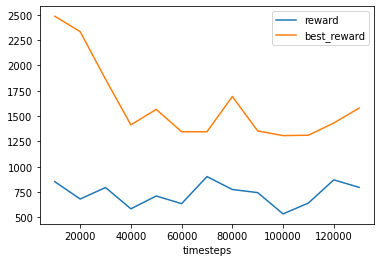

In [30]:
import pandas as pd
reward_log = pd.read_csv(reward_log_path, index_col='timesteps')
reward_log.plot()

最も良かった世代を選択します。

In [31]:
best_epoch = reward_log['reward'].idxmax()
print('best epoch:', best_epoch)

best epoch: 70000


## AIマリオのテスト

AIモデルをテストします。

### AIマリオのモデルの読み込み

#### 学習済みモデルを使用
学習済みモデルを使用する場合は、学習済みモデルを以下コマンドでダウンロードして読み込みます。

読み込んだら、次は飛ばして、AIマリオのプレイを実施してください。

In [38]:
import gdown
gdown.download('https://drive.google.com/uc?id=10lbU8FeiBE2J7BbwMik1ewy_s3jIZdt0', 'mario_1_1.zip', quiet=False)
model = PPO.load('mario_1_1')

Downloading...
From: https://drive.google.com/uc?id=10lbU8FeiBE2J7BbwMik1ewy_s3jIZdt0
To: /workspace/mario_1_1.zip
100%|██████████████████████████████████████| 17.7M/17.7M [00:01<00:00, 10.6MB/s]
/opt/conda/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


#### このノートブックで学習したモデルを使用
注：学習済みモデルを使用する場合は、ここは飛ばしてください。

このノートブックで学習したモデルを以下コマンドを実行して読み込みます。平均報酬が一番高い世代のモデルを読み込みます。

In [48]:
best_model_path = os.path.join(save_dir, 'best_model_{}'.format(best_epoch))
print(best_model_path)
model = PPO.load(best_model_path)

logs/2022-02-06T13-22-42/best_model_70000


#### AIマリオのプレイ
テストした結果を表示すると共に、1番良いときの画像ログデータを保存します。

In [49]:
import copy

total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []

for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0
    total_time[i] = 0
    frames = []
    while not done and total_time[i] < 10000:
        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        total_reward[i] += reward[0]
        total_time[i] += 1
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

test episode: 0 reward: 1322.0 time: 400
test episode: 1 reward: 236.0 time: 67
test episode: 2 reward: 617.0 time: 169
test episode: 3 reward: 1427.0 time: 327
test episode: 4 reward: 739.0 time: 240
test episode: 5 reward: 1046.0 time: 275
test episode: 6 reward: 1424.0 time: 385
test episode: 7 reward: 252.0 time: 56
test episode: 8 reward: 623.0 time: 140
test episode: 9 reward: 1037.0 time: 366
test episode: 10 reward: 604.0 time: 144
test episode: 11 reward: 736.0 time: 258
test episode: 12 reward: 631.0 time: 164
test episode: 13 reward: 1021.0 time: 525
test episode: 14 reward: 623.0 time: 160
test episode: 15 reward: 1346.0 time: 379
test episode: 16 reward: 622.0 time: 203
test episode: 17 reward: 252.0 time: 60
test episode: 18 reward: 1031.0 time: 434
test episode: 19 reward: 1423.0 time: 387
average reward: 850.6 average time: 256.95 best_reward: 1427.0


`best_reward`が3000を超えたらおそらくクリアできています。

低い報酬（`reward`）しか出ない場合は、何度かやり直してみてください。何度やっても高い報酬が出ない場合は、最初からやり直してみましょう。

## AIマリオのプレイ動画を保存・再生

保存した画像ログから動画を保存・再生します。

画像が多いと動画生成や確認に時間がかかるため、画像を間引きます。

画像を間引く割合を入力します（大きいほどたくさん間引きます）。

In [35]:
SKIP_RATE = 2

画像を間引く処理をします。

In [36]:
if SKIP_RATE == 1:
  frames_new = np.array(frames_best)
else:
  np_frames = np.array(frames_best)
  frames_new = np_frames[::SKIP_RATE].tolist()

Google Colab上で確認できる動画を生成します。生成後に再生ボタンを押すと、AIマリオのプレイ動画が見れます。

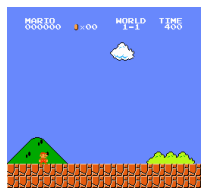

In [50]:
import matplotlib.animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
HTML(ani.to_jshtml())

動画形式で保存します。
H264は[大人の事情で扱いにくい](https://qiita.com/engineer/items/54e33bdacc173c84cc8a)のでMPEG4でエンコードします。

In [51]:
ani.save('ai_mario_{}.mp4'.format(STAGE_NAME), writer='ffmpeg', codec='mpeg4')

GIF動画を生成します。

In [52]:
# Reference
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import imageio
imageio.mimsave('ai_mario_{}.gif'.format(STAGE_NAME), [np.array(img) for i, img in enumerate(frames_best) if i%SKIP_RATE == 0], fps=29)

GIF動画をダウンロードします。

In [ ]:
# from google.colab import files
# files.download('ai_mario.gif')

## AIモデルとログのGoogle Driveへの保存

Google DriveへAIモデルとログ(Tensorboard)の保存をします。

In [ ]:
model.save('best_mario_model')

In [ ]:
cp best_mario_model.zip ./drive/MyDrive/mario_1_1.zip

In [ ]:
!tar cvzf mario_logs.tar.gz ./logs/
!cp mario_logs.tar.gz ./drive/MyDrive/

## まとめ
本ノートブックで1-1をクリアするAIマリオを生み出すことに成功しました。

## 参考情報
### 書籍
- OpenAI Gym／Baselines 深層学習・強化学習 人工知能プログラミング 実践入門
- 強化学習を学びたい人が最初に読む本

### Webリンク
- https://github.com/nicknochnack/MarioRL
- https://qiita.com/hrs1985/items/871ca5d037d73558bfca
- https://qiita.com/karaage0703/items/e237887894f0f1382d58
- https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
- https://github.com/YuansongFeng/MadMario